#### Binary Prediction with a Rainfall Dataset

Import all the necessary libraries needed for this project & Ensuring all that the data is ready for model training 

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import warnings
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
## loading the dataset

train_data = pd.read_csv('playground-series-s5e3/train.csv')
test_data = pd.read_csv('playground-series-s5e3/test.csv')

In [3]:
print(f'Training Data RangeIndex:- {train_data.shape[0]}, --- \n Total Columns {train_data.shape[1]} \n ')
print(f'Test Data RangeIndex:- {test_data.shape[0]}, ---  \n Total Columns {test_data.shape[1]}')

Training Data RangeIndex:- 2190, --- 
 Total Columns 13 
 
Test Data RangeIndex:- 730, ---  
 Total Columns 12


In [4]:
## understand statistical data for better understanding 
print('\n                                      === DESCRIPTIVE STATISTICAL DATA SUMMARY ===')
def create_summary(df):
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing Values'] = df.isnull().sum().values
    summary['Uniques Values'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Thrid Value'] = df.loc[2].values
    
    # Add descriptive statistics
    desc = df.describe().transpose()
    desc = desc.reset_index()
    desc = desc.rename(columns={'index': 'Name'})
    summary = pd.merge(summary, desc, on='Name', how='left')

    return summary

combined_df = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

create_summary(combined_df).style.background_gradient(cmap='Oranges')



                                      === DESCRIPTIVE STATISTICAL DATA SUMMARY ===


,Name,dtypes,Missing Values,Uniques Values,First Value,Second Value,Thrid Value,count,mean,std,min,25%,50%,75%,max
0,id,int64,0,2920,0.000000,1.000000,2.000000,2920.000000,1459.500000,843.075718,0.000000,729.750000,1459.500000,2189.250000,2919.000000
1,day,int64,0,365,1.000000,2.000000,3.000000,2920.000000,180.711301,105.252537,1.000000,89.750000,180.000000,271.000000,365.000000
2,pressure,float64,0,244,1017.400000,1019.500000,1024.100000,2920.000000,1013.577363,5.617592,999.000000,1008.600000,1013.000000,1017.700000,1034.600000
3,maxtemp,float64,0,226,21.200000,16.200000,19.400000,2920.000000,26.367466,5.657912,7.400000,21.300000,27.800000,31.200000,36.000000
4,temparature,float64,0,206,20.600000,16.900000,16.100000,2920.000000,23.955616,5.235483,5.900000,19.400000,25.500000,28.400000,31.800000
5,mintemp,float64,0,205,19.900000,15.800000,14.600000,2920.000000,22.155137,5.086431,4.000000,17.700000,23.900000,26.400000,29.800000
6,dewpoint,float64,0,227,19.400000,15.400000,9.300000,2920.000000,20.455959,5.313356,-0.300000,16.800000,22.200000,25.000000,26.700000
7,humidity,float64,0,50,87.000000,95.000000,75.000000,2920.000000,82.194863,7.808651,39.000000,77.000000,82.000000,88.000000,98.000000
8,cloud,float64,0,81,88.000000,91.000000,47.000000,2920.000000,75.881507,18.002503,0.000000,69.000000,83.000000,88.000000,100.000000
9,sunshine,float64,0,121,1.100000,0.000000,8.300000,2920.000000,3.724418,3.629109,0.000000,0.400000,2.400000,6.800000,12.100000


#### 📌 Handling Missing Values



#### ✅ Choose a Strategy Based on Context in  Machine Learning-Based Imputation Methods

SimpleImputer tool will use to replaces missing values using a median strategy:

In [5]:
missing_values = pd.DataFrame({
    "Missing Value Training": train_data.isnull().sum(),
    "Missing Value Test": test_data.isnull().sum()
})

missing_values

,Missing Value Training,Missing Value Test
cloud,0,0.0
day,0,0.0
dewpoint,0,0.0
humidity,0,0.0
id,0,0.0
maxtemp,0,0.0
mintemp,0,0.0
pressure,0,0.0
rainfall,0,NaN
sunshine,0,0.0


In [6]:
imputation = SimpleImputer(strategy='median')
if train_data.isnull().sum().sum() > 0:
    train_fill = imputation.fit_transform(train_data.select_dtypes(include=[np.number]))
    train_data = pd.DataFrame(train_fill, columns=train_data.select_dtypes(include=[np.number]).columns)
if test_data.isnull().sum().sum() > 0:
    test_fill = imputation.fit_transform(test_data.select_dtypes(include=[np.number]))
    test_data = pd.DataFrame(test_fill, columns=test_data.select_dtypes(include=[np.number]).columns)

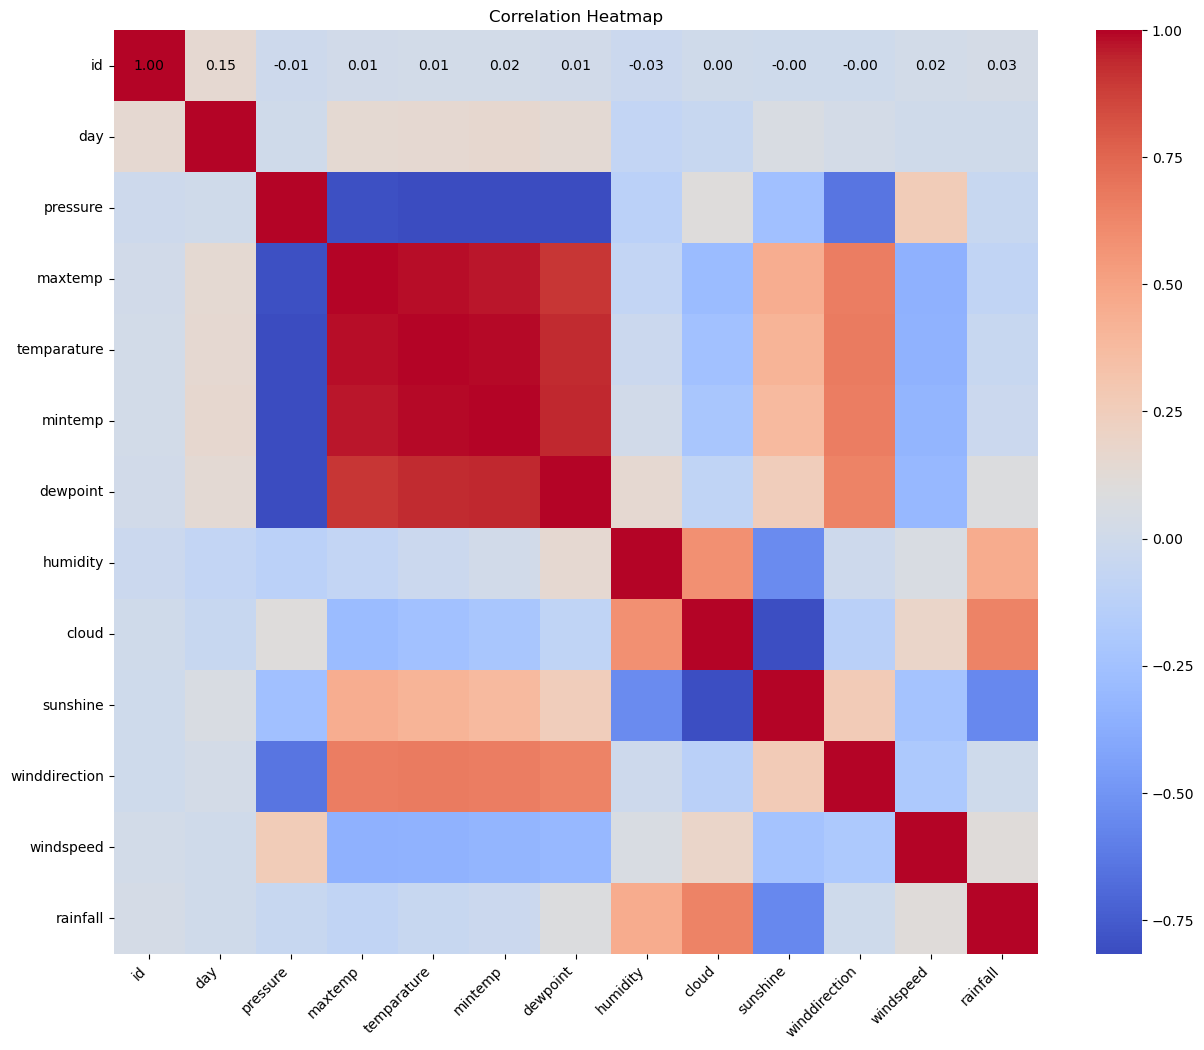

In [7]:
corr = train_data.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, annot_kws={"size": 10, "color": "black"})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Heatmap")
plt.show()

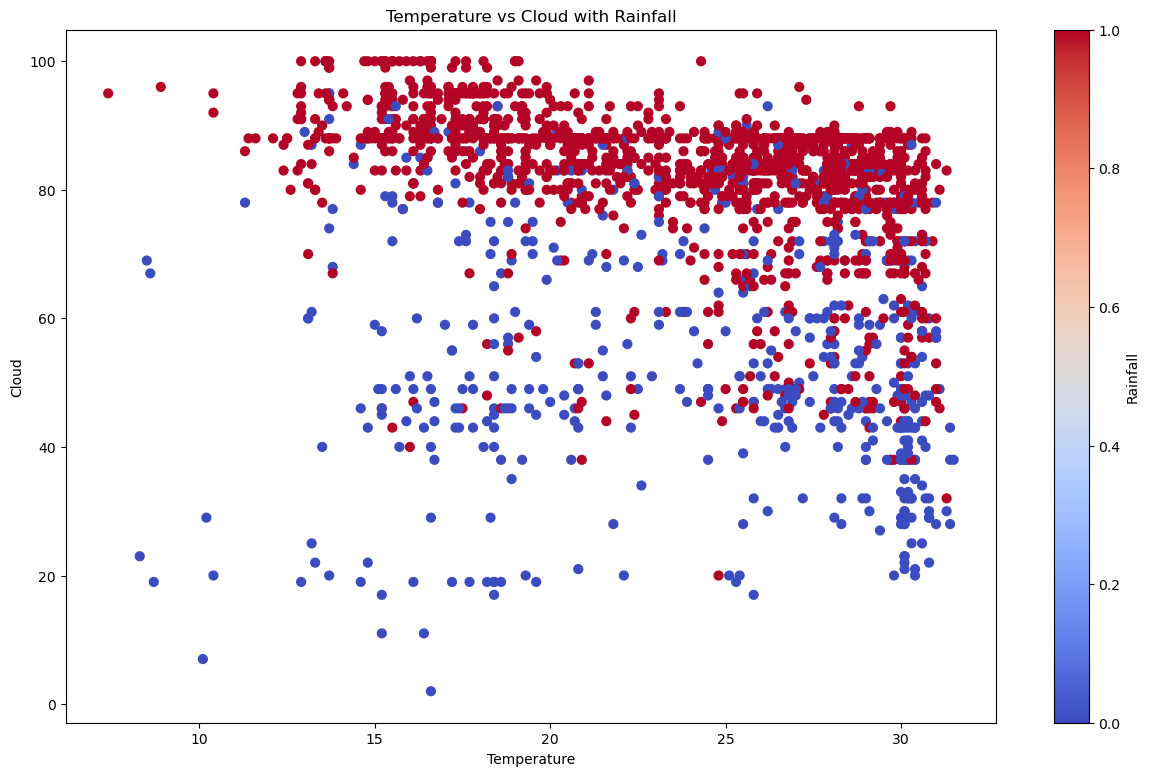

In [8]:
fig, ax = plt.subplots(figsize=(15,9))

# Normalize rainfall values to [0,1] for colormap
norm = plt.Normalize(train_data['rainfall'].min(), train_data['rainfall'].max())
cmap = cm.coolwarm

# Create scatter with color mapping
sc = ax.scatter(
    train_data['temparature'],
    train_data['cloud'],
    c=train_data['rainfall'],
    cmap=cmap,
    s=40,
)

# Add colorbar to show rainfall mapping
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Rainfall")

plt.xlabel("Temperature")
plt.ylabel("Cloud")
plt.title("Temperature vs Cloud with Rainfall")
plt.show()

#### Checking if there's any outlier in the dataset

In [9]:

# Create an empty list to store column names where outliers are found
outlier_features = []

for col in train_data.columns:
    data = train_data[col]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    if len(outliers) > 0:  
        outlier_features.append(col)
        print(f"{col}: {len(outliers)} Outliers")

# Finally, outlier_features will contain names of columns that have outliers
print("\nFeatures containing Outliers:", outlier_features)

pressure: 4 Outliers
mintemp: 1 Outliers
dewpoint: 26 Outliers
humidity: 28 Outliers
cloud: 129 Outliers
windspeed: 28 Outliers
rainfall: 540 Outliers

Features containing Outliers: ['pressure', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'windspeed', 'rainfall']


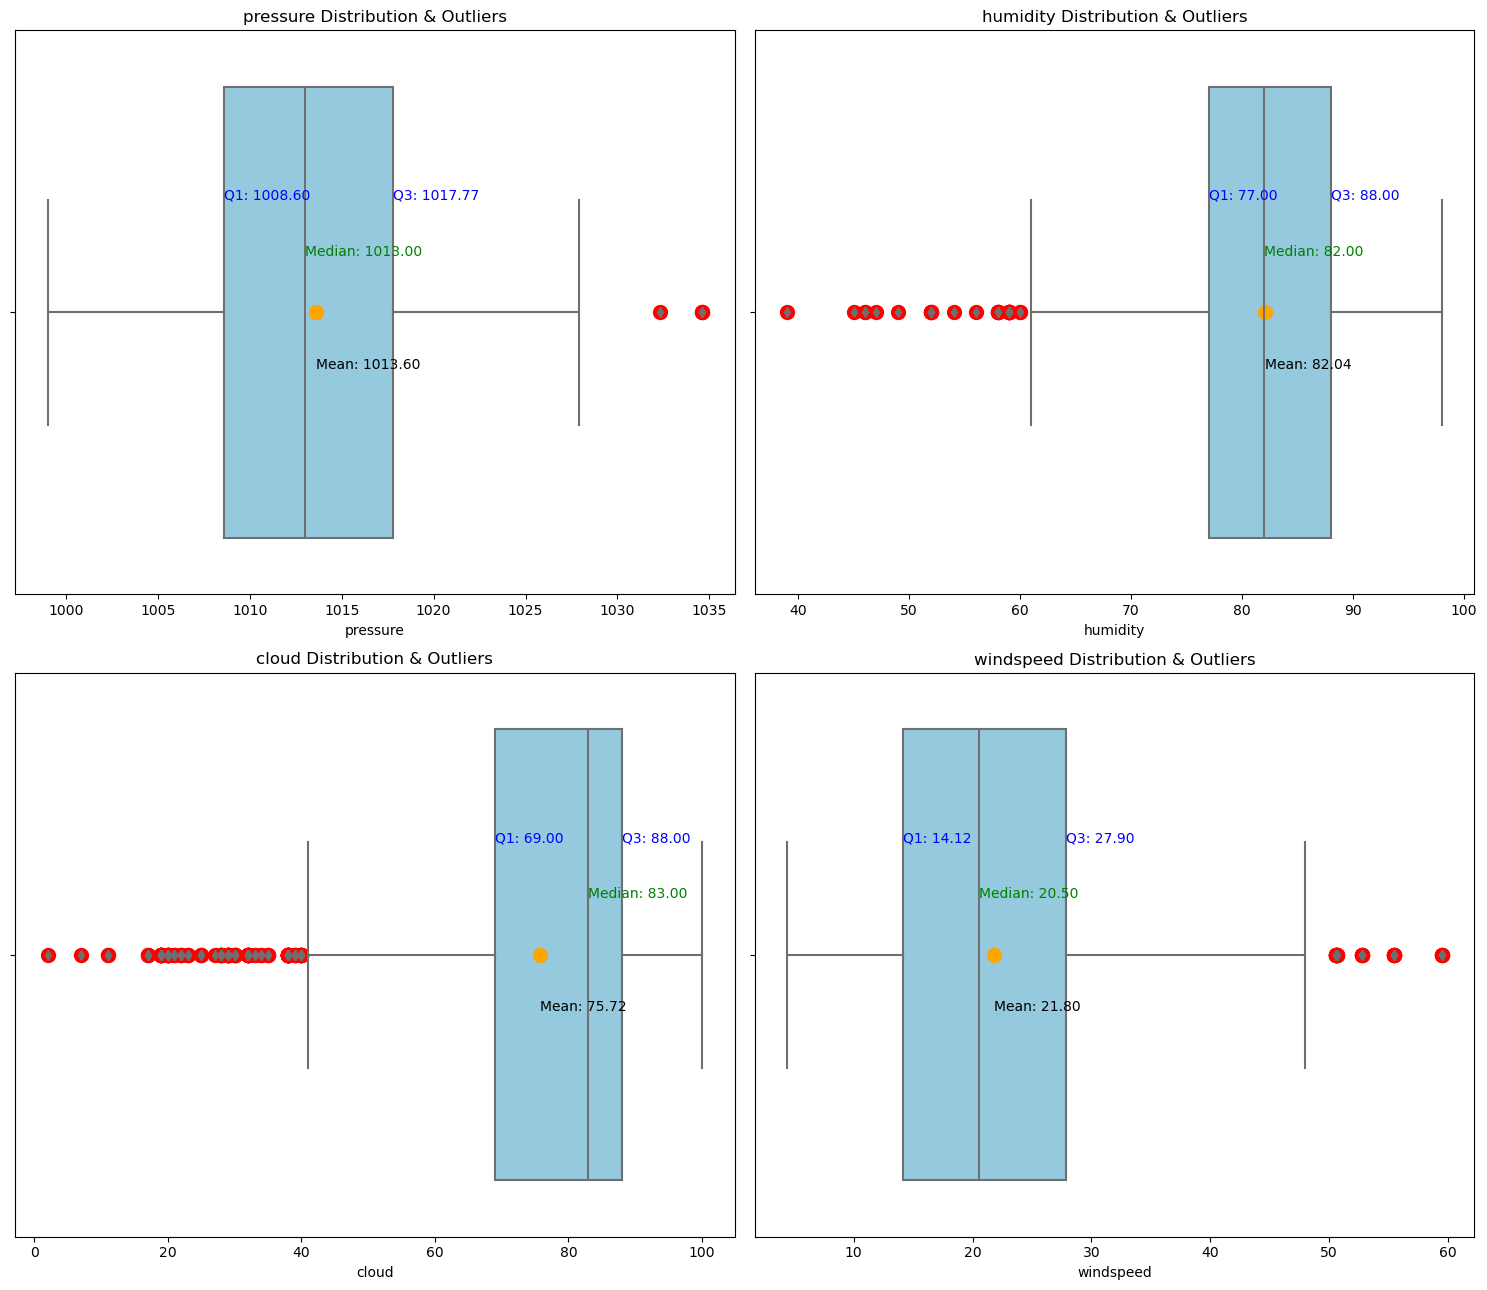

In [10]:
plt.figure(figsize=(15, 13))

columns = [
    'pressure', 'humidity', 'cloud', 'windspeed'
]
# Loop through each column and plot a boxplot with statistics
for i, col in enumerate(columns):
    plt.subplot(2, 2, i+1)
    
    data = train_data[col]
    
    # Draw boxplot
    sns.boxplot(x=data, color='skyblue')
    
    # === Calculate descriptive statistics ===
    mean_val = data.mean()
    median_val = data.median()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # === Add statistics and annotations on the plot ===
    plt.scatter(mean_val, 0, color='orange', marker='o', s=100, label='Mean')
    
    # Annotate min, max, median
    plt.text(mean_val, 0.1, f'Mean: {mean_val:.2f}', color='black')
    plt.text(median_val, -0.1, f'Median: {median_val:.2f}', color='green')
    plt.text(q1, -0.2, f'Q1: {q1:.2f}', color='blue')
    plt.text(q3, -0.2, f'Q3: {q3:.2f}', color='blue')
    
    # === Highlight outliers ===
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    for out in outliers:
        plt.scatter(out, 0, color='red', marker='o', s=100)
    
    plt.title(f'{col} Distribution & Outliers')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [11]:
# Define a function to "cap" outliers (replace them with lower/upper limits)

def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Step 3: Replace values outside bounds with the nearest bound
    # If value < lower, replace with lower
    # If value > upper, replace with upper
    # Otherwise, keep value unchanged
    return np.where(series < lower, lower,
                    np.where(series > upper, upper, series))

# Apply the function to each selected column in the dataset
for col in ['pressure', 'humidity', 'cloud', 'windspeed']:
    train_data[col] = cap_outliers(train_data[col])

#### Before proceeding with data validation and feature selection, let's first examine whether the target variable is `Balanced`.

(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

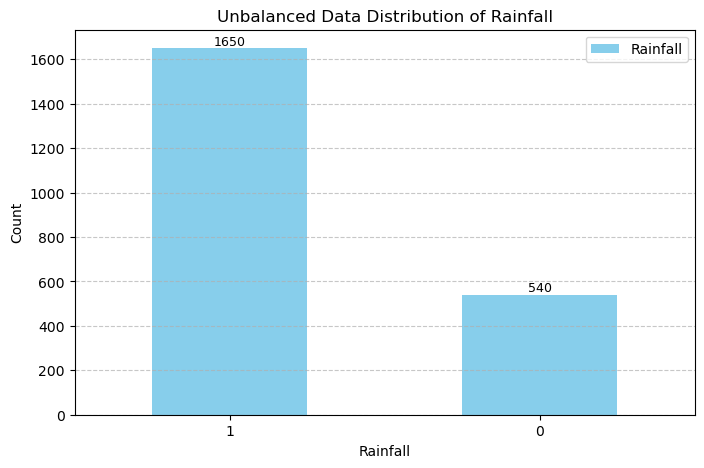

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
train_data['rainfall'].value_counts().plot(kind='bar', color='skyblue', label='Rainfall')
for x in ax.containers:
    ax.bar_label(x, fontsize=9)
plt.legend()
plt.grid(axis='y', ls='--', alpha=0.7)
plt.title('Unbalanced Data Distribution of Rainfall')
plt.xlabel('Rainfall')
plt.ylabel('Count')
plt.xticks(rotation=0)

### NOTE: The target variable `rainfall` is unbalanced.
There are 1650 instances of one class and 540 of the other.
This imbalance may bias the model towards the majority class.
Consider resampling techniques (oversampling/undersampling), class weights, or SMOTE.

In [13]:
# Validate & Seperate Feature & target
X = train_data.iloc[:,1:-1]
target = train_data.iloc[:, -1]

test_features = test_data.iloc[:,1:]
y_test_features = test_data.iloc[:, -1]

In [14]:
# CHECK FOR HIGHLY CORRELATED FEATURES

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"Highly correlated features: {high_corr_features}")

# Drop highly correlated features from both train and test sets
if high_corr_features:
    X = X.drop(high_corr_features, axis=1)
    X_test = test_features.drop(high_corr_features, axis=1)
    
    print(f"Removed features: {high_corr_features}")

Highly correlated features: ['temparature', 'mintemp', 'dewpoint']
Removed features: ['temparature', 'mintemp', 'dewpoint']


In [15]:
X_test.head()

,day,pressure,maxtemp,humidity,cloud,sunshine,winddirection,windspeed
0,1.0,1019.5,17.5,96.0,99.0,0.0,50.0,24.3
1,2.0,1016.5,17.5,97.0,99.0,0.0,50.0,35.3
2,3.0,1023.9,11.2,86.0,96.0,0.0,40.0,16.9
3,4.0,1022.9,20.6,75.0,45.0,7.1,20.0,50.6
4,5.0,1022.2,16.1,68.0,49.0,9.2,20.0,19.4


Original training class distribution: [ 540 1650]
Resampled training class distribution: [1650 1650]


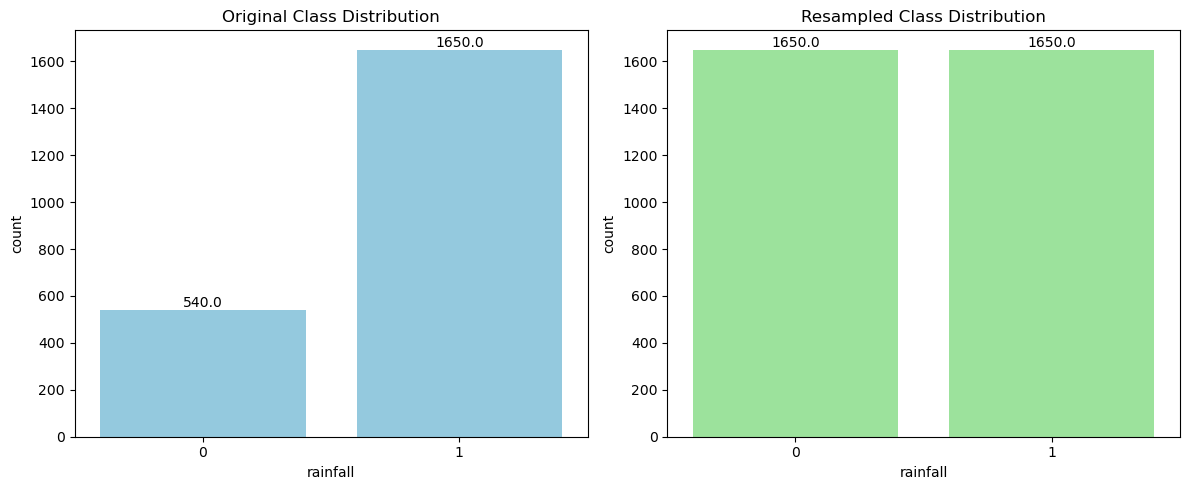

In [19]:
# Apply SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
# Generate a balanced dataset
X_train_sampled, Y_train_sampled = smote.fit_resample(X, target)
print(f'Original training class distribution: {np.bincount(target)}')
print(f'Resampled training class distribution: {np.bincount(Y_train_sampled)}')


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=target, ax=axes[0], color='skyblue')
axes[0].set_title('Original Class Distribution')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10)
sns.countplot(x=Y_train_sampled, ax=axes[1], color='lightgreen')
axes[1].set_title('Resampled Class Distribution')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [20]:
# Split the data into training and validation sets
# stratify : is to Ensures class distribution is maintained in both sets (important for imbalanced data)

x_train, x_test, y_train, y_test = train_test_split(
    X, target, 
    test_size=0.2, 
    stratify=target, 
    random_state=2
)

# Check sizes of the splits
print(f'Training set size: {x_train.shape[0]} samples')
print(f'Validation set size: {x_test.shape[0]} samples')

Training set size: 1752 samples
Validation set size: 438 samples


In [21]:
# Check class distribution
print(f"\nClass distribution:\n{target.value_counts()} \n")
print(f"Rainfall percentage: {target.mean():.2%}")


Class distribution:
rainfall
1    1650
0     540
Name: count, dtype: int64 

Rainfall percentage: 75.34%


In [22]:
# Initialize Random Forest Classifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators' : [100, 200, 300], 
    'max_depth' : [None, 5, 10], 
    'max_features' : ['sqrt', 'log2', 0.5],
    'min_samples_split' : [2,5,10], 
    'min_samples_leaf' : [1,2,4]
    
}

In [23]:
### # Setup GridSearchCV and specify scoring metric separately

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring=['f1', 'roc_auc'],refit='f1'  )
grid_search.fit(X_train_sampled, Y_train_sampled)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['sqrt', 'log2', 0.5],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='f1', scoring=['f1', 'roc_auc'], verbose=2)

In [24]:
print("Best Params:", grid_search.best_params_)
print("Best Estimator for Random Forest:", grid_search.best_estimator_)
print(f"Best ROC-AUC Score from Grid Search: {grid_search.best_score_}")

Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Estimator for Random Forest: RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)
Best ROC-AUC Score from Grid Search: 0.8892923619364523


In [25]:
##### Cross-Validation for Model Evaluation
cv_score = cross_val_score(grid_search.best_estimator_, X_train_sampled, Y_train_sampled, cv=5, scoring='f1')
cv_score_1 = cross_val_score(grid_search.best_estimator_, X_train_sampled, Y_train_sampled, cv=5, scoring='roc_auc')

print('\n Cross-validation F1 scores for each fold:', cv_score)
print('Mean cross-validation F1 score:', round(np.mean(cv_score), 3))
print('Standard deviation of F1 scores:', round(np.std(cv_score), 3))
print('=================================================================')
print('\n--- ROC-AUC Score ---\n ')
print('Cross-validation ROC-AUC scores for each fold:', cv_score_1)
print('Mean ROC-AUC score:', round(np.mean(cv_score_1), 3))
print('Standard deviation:', round(np.std(cv_score_1), 3))

Cross-validation F1 scores for each fold: [0.87007299 0.88217523 0.90062112 0.89481947 0.89877301]
Mean cross-validation F1 score: 0.889
Standard deviation of F1 scores: 0.012

--- ROC-AUC Score ---
 
Cross-validation ROC-AUC scores for each fold: [0.93866391 0.93075758 0.96945822 0.96741506 0.96597337]
Mean ROC-AUC score: 0.954
Standard deviation: 0.016


In [26]:
y_predict = grid_search.best_estimator_.predict(x_test)

print("\n Validation Accuracy:", accuracy_score(y_test, y_predict), "\n ")
print("====================================================================")
print("\n Validation Confusion Matrix:\n", confusion_matrix(y_test, y_predict), "\n ")
print("====================================================================")
print("\n Validation Classification Report:\n", classification_report(y_test, y_predict), "\n")


 Validation Accuracy: 1.0 
 

 Validation Confusion Matrix:
 [[108   0]
 [  0 330]] 
 

 Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00       330

    accuracy                           1.00       438
   macro avg       1.00      1.00      1.00       438
weighted avg       1.00      1.00      1.00       438
 



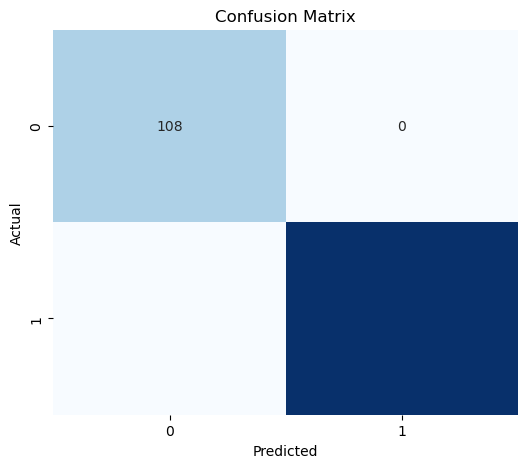

In [27]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

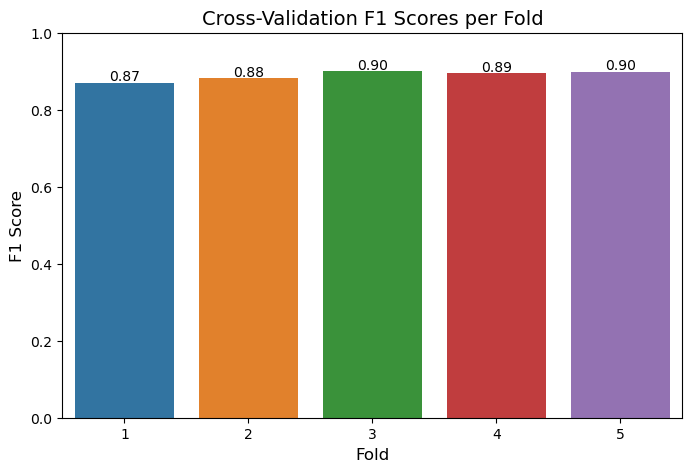

In [28]:
# Example cross-validation F1 scores
cv_f1_scores = [0.87007299, 0.88217523, 0.90062112, 0.89481947, 0.89877301]

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=np.arange(1, len(cv_f1_scores)+1), y=cv_f1_scores)
plt.ylim(0, 1)
plt.title("Cross-Validation F1 Scores per Fold", fontsize=14)
plt.xlabel("Fold", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)

# Annotate values on top of bars
for i, score in enumerate(cv_f1_scores):
    plt.text(i, score + 0.005, f"{score:.2f}", ha='center', fontsize=10)

plt.show()

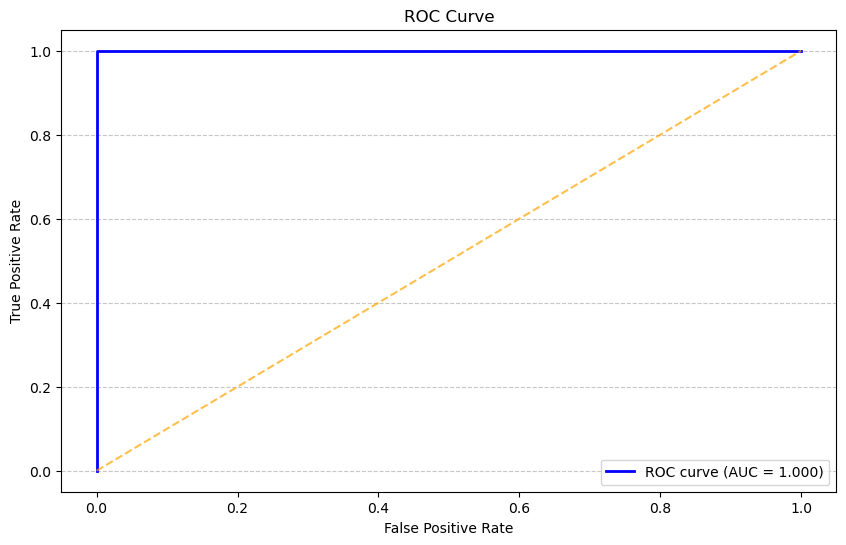

In [55]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='orange', alpha=0.7, linestyle='--')  # random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(ls='--', alpha=0.7, axis='y')
plt.savefig('ROC Curve.png')
plt.show()


In [30]:
### Let's have random dataset to check the prediction

value = (53, 1066.2, 20.5, 85.2, 66.0, 0.0, 62.9, 60)

value_df = pd.DataFrame([value], columns=['day', 'pressure', 'maxtemp', 'humidity', 'cloud', 'sunshine',
       'winddirection', 'windspeed'])

value_df.head()

,day,pressure,maxtemp,humidity,cloud,sunshine,winddirection,windspeed
0,53,1066.2,20.5,85.2,66.0,0.0,62.9,60


In [31]:
prediction = grid_search.best_estimator_.predict(value_df)

print("\n ",prediction, "\n ")
print("Prediction Result: ", "Rainfall" if prediction[0] == 1 else "Not Rainfull")



  [1] 
 
Prediction Result:  Rainfall


In [32]:
y_pred = grid_search.best_estimator_.predict(X_test)

## Model Comparison Note

As we have seen, the RandomForest Classifier has been trained and evaluated, demonstrating strong performance on our dataset.

Next, we will explore additional machine learning models, including `XGBoost`, `LightGBM`, and `CatBoost`, to evaluate and compare their performance. This comparison will help us identify the **model that best fits our problem of predicting rainfall**.

By performing this evaluation, we ensure that our final model is not only accurate but also ***robust and well-suited for the imbalanced nature of the dataset***.

In [33]:
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200, max_depth=10, random_state=42,
        class_weight='balanced'
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42, eval_metric='logloss',
        scale_pos_weight=(len(target) - target.sum()) / target.sum()
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42,
        class_weight='balanced'
    ),
    'CatBoost': CatBoostClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42, verbose=0,
        auto_class_weights='Balanced'
    ),
}

In [34]:
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_sampled, Y_train_sampled)
    y_pred_proba = model.predict_proba(x_test)[:, 1]  
    
    auc_score = roc_auc_score(y_test, y_pred_proba)
    results[name] = auc_score
    print(f"{name} ROC AUC: {auc_score:.4f}")


Training RandomForest...
RandomForest ROC AUC: 0.9889

Training XGBoost...
XGBoost ROC AUC: 0.9956

Training LightGBM...
[LightGBM] [Info] Number of positive: 1650, number of negative: 1650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 3300, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

CatBoost ROC AUC: 0.9855


### **Goal:** Identify the most promising model and optimize its hyperparameters to improve performance.

Evaluate multiple models (`RandomForest, XGBoost, LightGBM, CatBoost`) and select the best one based on **`ROC-AUC`**.

Define a grid of hyperparameters to search (number of `trees`, `tree depth`, `learning rate`).

Retrieve the best estimator and parameters. Optimized model will be ready for evaluation on test data

In [47]:
best_model_name = max(results, key=results.get)
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
if best_model_name == 'RandomForest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5]
    }
    base_model = RandomForestClassifier(class_weight='balanced', random_state=42)
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2]
    }
    base_model = XGBClassifier(random_state=42, eval_metric='logloss',
                              scale_pos_weight=(len(Y_train_sampled) - Y_train_sampled.sum()) / Y_train_sampled.sum())
elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2]
    }
    base_model = LGBMClassifier(class_weight='balanced', random_state=42)
else:  # CatBoost
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2]
    }
    base_model = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')

grid_search_for_all_model = GridSearchCV(base_model, param_grid, cv=3, scoring='roc_auc', n_jobs=1)

grid_search_for_all_model.fit(X_train_sampled, Y_train_sampled)

best_model = grid_search_for_all_model.best_estimator_

print(f"Best parameters for {best_model_name}: {grid_search_for_all_model.best_params_}")



Performing hyperparameter tuning for LightGBM...
[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1983
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1983
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1100, number of negative: 1100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Cross-Validation with the Best Model

In this step, we perform **cross-validation** to evaluate the performance of our best model on the training data. This helps us estimate how well the model generalizes to unseen data.

In [36]:
print(f"\nPerforming cross-validation with {best_model_name}...")
cv_scores = cross_val_score(best_model, X_train_sampled, Y_train_sampled, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            scoring='roc_auc', n_jobs=1)
print(f"{best_model_name} Cross-Validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Performing cross-validation with LightGBM...
[LightGBM] [Info] Number of positive: 1320, number of negative: 1320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 2640, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [39]:
print("\nTraining ensemble model...")
ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft',
    weights=[results[name] for name in models.keys()]
)
ensemble.fit(X_train_sampled, Y_train_sampled)
y_pred_proba = ensemble.predict_proba(x_test)[:, 1]
print(f"Ensemble ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Training ensemble model...
[LightGBM] [Info] Number of positive: 1650, number of negative: 1650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 3300, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

Ensemble ROC AUC: 0.9968


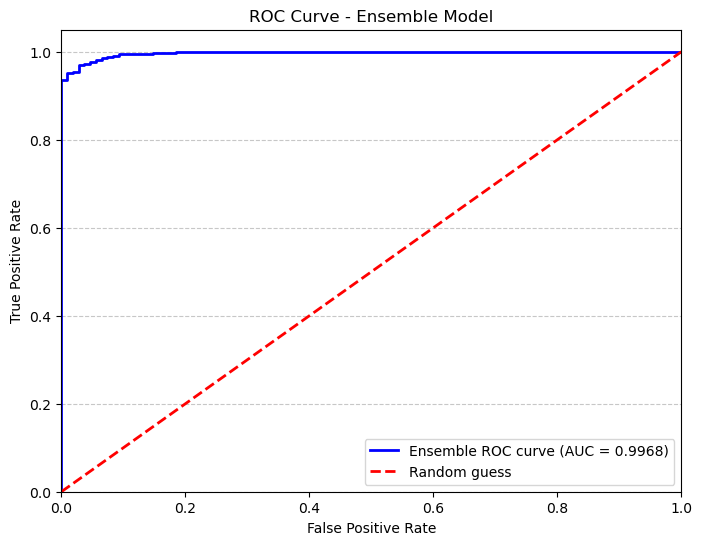

In [50]:
y_pred_proba = ensemble.predict_proba(x_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Ensemble ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend(loc="lower right")
plt.grid(ls='--', alpha=0.7, axis='y')
plt.show()

In [41]:
# Train final model (ensemble or best tuned model based on validation performance)
final_model = ensemble if roc_auc_score(y_test, y_pred_proba) > results[best_model_name] else best_model
print(f"\nTraining final model ({'ensemble' if final_model == ensemble else best_model_name}) on all data...")
final_model.fit(x_test, y_test)


Training final model (LightGBM) on all data...
[LightGBM] [Info] Number of positive: 330, number of negative: 108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 438, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_depth=9,
               n_estimators=300, random_state=42)

In [42]:
y_prediction_LGBMClassifier = final_model.predict_proba(X_test)[:,1]

In [44]:
subm_RandomForst = pd.DataFrame({
    'id' : test_data['id'],
    'Rainfall' : y_pred
})

subm_RandomForst.to_csv('Submission_RandomForest.csv', index=None)
subm_RandomForst.head(10)

,id,Rainfall
0,2190.0,1
1,2191.0,1
2,2192.0,1
3,2193.0,0
4,2194.0,0
5,2195.0,1
6,2196.0,1
7,2197.0,1
8,2198.0,1
9,2199.0,1


In [46]:
subm_LGBMClassifier = pd.DataFrame({
    'id' : test_data['id'],
    'Rainfall' : y_prediction_LGBMClassifier
})

subm_LGBMClassifier.to_csv('Submission_LGBMClassifier.csv', index=None)
subm_LGBMClassifier.head(10)


,id,Rainfall
0,2190.0,1.000000
1,2191.0,1.000000
2,2192.0,0.999997
3,2193.0,0.017537
4,2194.0,0.000127
5,2195.0,0.997026
6,2196.0,1.000000
7,2197.0,1.000000
8,2198.0,1.000000
9,2199.0,1.000000
